Post process 3D bbx tracking data produced in April 2021
Goals
1. rectify 3D bbox measurements into comprehensible trajecotry data for enhancing training
2. manual validate the rectified measurements with the videos

Tasks
1. compute homography matrix (done)
2. transform bottom 4 poitns into real-world coords (done)
3. work on the road plane (done)
4. use optimization to rectify measurements (done)
5. add motion (velocity. acceleration) constraints in optimization (done)
6. optimization switch direction south/north bound
6. Apply Joint Probabilistic Data Association algorithm (JPDA)
    https://stonesoup.readthedocs.io/en/latest/auto_tutorials/08_JPDATutorial.html
    a. one object has 4 measurements

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = 'rectified_dynamics/rectified_p2c2.csv'
file_path = data_path.joinpath(file_name)
tform_path = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
df = utils.read_data(file_path)


In [3]:
car = df[df['ID']==2261]
car['width'] = 2
car['length'] = 4
car

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Frame #,Timestamp,ID,Object class,Generation method,fbrx,fbry,fblx,fbly,...,bbl_x,bbl_y,direction,acceleration,speed,x,y,theta,width,length
169,169,63,1.758016e+09,2261,van,Manual Annotation,3479.619808,1043.559165,3397.704804,1095.012696,...,248.756195,32.761360,-1.0,1.513593e-08,31.147005,248.756218,33.762139,3.141570,2,4
170,170,64,1.758016e+09,2261,van,NaN,3414.199036,1012.796049,3337.412016,1056.854948,...,247.822303,32.761381,-1.0,2.959045e-08,31.147005,247.822225,33.762160,3.141671,2,4
171,171,65,1.758016e+09,2261,van,NaN,3364.576577,967.920083,3279.768248,1018.520816,...,246.781106,32.761300,-1.0,4.257699e-08,31.147005,246.781341,33.762078,3.141358,2,4
172,172,66,1.758016e+09,2261,van,Detector,3311.606798,930.043210,3223.595830,982.890398,...,245.641279,32.761568,-1.0,3.039883e-08,31.147005,245.641521,33.762346,3.141352,2,4
173,173,67,1.758016e+09,2261,van,Localizer,3255.051164,897.402799,3169.456800,946.807376,...,244.706918,32.761793,-1.0,3.255376e-08,31.147005,244.707104,33.762571,3.141407,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,232,126,1.758016e+09,2261,van,Detector,NaN,NaN,NaN,NaN,...,183.347523,32.797325,-1.0,-4.289061e-08,31.147005,183.347528,33.798103,3.141588,2,4
233,233,127,1.758016e+09,2261,van,Localizer,NaN,NaN,NaN,NaN,...,182.413106,32.797330,-1.0,-4.289061e-08,31.147005,182.413111,33.798108,3.141588,2,4
234,234,128,1.758016e+09,2261,van,Localizer,NaN,NaN,NaN,NaN,...,181.167227,32.797336,-1.0,-4.289061e-08,31.147005,181.167232,33.798114,3.141588,2,4
235,235,129,1.758016e+09,2261,van,Localizer,NaN,NaN,NaN,NaN,...,180.232818,32.797340,-1.0,-4.289061e-08,31.147005,180.232823,33.798119,3.141588,2,4


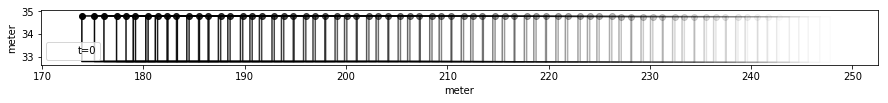

In [4]:
Y = np.array(car[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(Y,15,1)

In [7]:
n = 5
frames = np.arange(3-n,3)
frames[frames>=0]

array([0, 1, 2])

In [90]:
import utils
importlib.reload(utils)
car = utils.backward_predict(car,170,300,'xmax')

50


In [91]:
car

,Frame #,x,y,bbr_x,bbr_y,fbr_x,fbr_y,fbl_x,fbl_y,bbl_x,...,btlx,btly,fbrlat,fbrlon,fbllat,fbllon,bbrlat,bbrlon,bbllat,bbllon
0,13,300.667894,33.762139,300.667916,34.762139,296.667916,34.762229,296.667871,32.762229,300.667871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14,299.629660,33.762139,299.629683,34.762139,295.629683,34.762229,295.629638,32.762229,299.629638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,298.591427,33.762139,298.591449,34.762139,294.591449,34.762229,294.591404,32.762229,298.591404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,297.553193,33.762139,297.553216,34.762139,293.553216,34.762229,293.553171,32.762229,297.553171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,296.514960,33.762139,296.514982,34.762139,292.514982,34.762229,292.514937,32.762229,296.514937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,126,183.347528,33.798103,183.347533,34.798882,178.277680,34.798907,178.277670,32.797350,183.347523,...,NaN,NaN,36.003676,-86.608358,36.003664,-86.608375,36.003643,-86.608320,36.003631,-86.608337
233,127,182.413111,33.798108,182.413116,34.798887,177.343263,34.798911,177.343253,32.797354,182.413106,...,NaN,NaN,36.003683,-86.608365,36.003671,-86.608382,36.003649,-86.608327,36.003637,-86.608344
234,128,181.167232,33.798114,181.167237,34.798893,176.097384,34.798917,176.097374,32.797360,181.167227,...,NaN,NaN,36.003691,-86.608374,36.003679,-86.608391,36.003657,-86.608337,36.003645,-86.608353
235,129,180.232823,33.798119,180.232828,34.798897,175.162975,34.798922,175.162965,32.797365,180.232818,...,NaN,NaN,36.003697,-86.608381,36.003685,-86.608398,36.003663,-86.608344,36.003651,-86.608360


In [ ]:
df = utils.preprocess(file_path, tform_path)
df = opt.rectify(df)
df

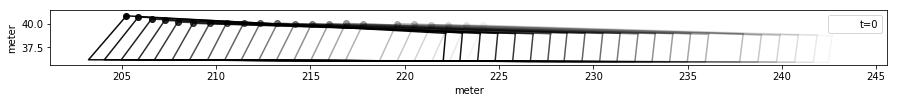

In [13]:
dfs = df[df['ID']==3261]
# plot 
D = np.array(dfs[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D,15,1)

In [14]:
dfs

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbllon,bbr_x,bbr_y,fbr_x,fbr_y,fbl_x,fbl_y,bbl_x,bbl_y,direction
238,137,1.758016e+09,3261,semi,2626.000000,272.000000,3694.000000,984.000000,-54.936836,-38.062466,...,-86.607863,243.579668,38.785168,225.032994,39.867788,224.217885,36.074393,243.382932,35.935016,-1.0
239,138,1.758016e+09,3261,semi,2596.000000,226.000000,3652.000000,950.000000,-63.614944,-21.960085,...,-86.607870,242.654575,38.699518,224.139250,39.812361,223.288908,36.067552,242.466205,35.928112,-1.0
240,139,1.758016e+09,3261,semi,2552.000000,230.000000,3586.000000,922.000000,-58.124989,-21.330208,...,-86.607875,241.863233,38.786440,223.222922,39.870027,222.377260,36.080167,241.672363,35.939856,-1.0
241,140,1.758016e+09,3261,semi,2524.000000,210.000000,3540.000000,878.000000,-37.637733,-20.988503,...,-86.607883,240.867541,38.785072,222.315823,39.876433,221.448350,36.080424,240.680070,35.940586,-1.0
242,141,1.758016e+09,3261,semi,2490.000000,190.000000,3490.000000,848.000000,-29.337967,-19.775991,...,-86.607890,239.896053,38.756704,221.396934,39.864253,220.502087,36.099057,239.714807,35.959331,-1.0
243,142,1.758016e+09,3261,semi,2450.000000,168.000000,3450.000000,828.000000,-27.635162,-19.009109,...,-86.607897,238.911011,38.806239,220.502051,39.897400,219.602865,36.093208,238.729460,35.954131,-1.0
244,143,1.758016e+09,3261,semi,2418.000000,158.000000,3384.000000,810.000000,-27.460377,-17.471193,...,-86.607904,237.945954,38.922526,219.565077,39.991745,218.665798,36.105055,237.761076,35.966194,-1.0
245,144,1.758016e+09,3261,semi,2346.000000,134.000000,3278.000000,750.000000,-51.715775,-9.676199,...,-86.607918,236.112259,38.861966,217.783641,39.937944,216.849765,36.101454,235.937050,35.962681,-1.0
246,145,1.758016e+09,3261,semi,2320.000000,92.000000,3236.000000,710.000000,-38.786846,-12.539722,...,-86.607925,235.156714,38.945357,216.863473,40.005599,215.926963,36.115985,234.980635,35.977438,-1.0
247,146,1.758016e+09,3261,semi,2286.000000,82.000000,3196.000000,674.000000,-28.566864,-13.386244,...,-86.607932,234.216597,38.936258,215.959670,39.992276,215.012141,36.116296,234.044283,35.977917,-1.0


In [26]:
import utils
importlib.reload(utils)
A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002114, -86.607129]
AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
Y1gps = np.array(df[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])[19:20,:]
# Y2gps = np.array(Y1re[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])[-200:-150,:]
# Ygps = np.vstack([Y1gps,Y2gps])
# Y_test = utils.gps_to_road(Y1gps,A,B)
# Ygps_test = utils.road_to_gps(Y1,A,B)

utils.draw_map_box(Y1gps, 30, lats,lngs)


###############################

 Beginning Key Insertion ...

Key Insertion Completed!!


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:231: ResourceWarning: unclosed file <_io.TextIOWrapper name='test.html' mode='r' encoding='cp1252'>
  htmltxt = open(fname, 'r').read()
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:235: ResourceWarning: unclosed file <_io.TextIOWrapper name='test.html' mode='w' encoding='cp1252'>
  open(fname, 'w').write(newtxt)


In [27]:
import utils
importlib.reload(utils)
utils.euclidean_distance(Y1gps[0,0],Y1gps[0,1],Y1gps[0,2],Y1gps[0,3])

(3.373142507245486, -2.245653067747062, 2.5169689456774336)

In [22]:
Y1gps

array([[ 36.00354491, -86.60826197,  36.00357117, -86.60829093,
         36.00358357, -86.60827878,  36.00355794, -86.60825266]])

In [73]:
Ygps = np.array(df[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
print(np.count_nonzero(~np.isnan(np.sum(Ygps,axis=-1))))
print(np.count_nonzero(~np.isnan(np.sum(Y,axis=-1))))

7801
7801


90  unique cars
28261


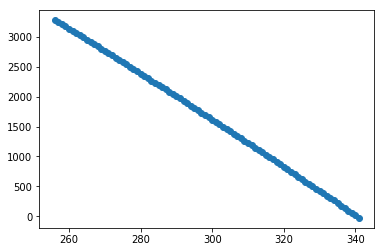

In [12]:
# debug missing timestamps in videos
groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,' unique cars')

for i in range(nO):
    ID = groupList[i]
    if (ID==28261):
        Y1 = groups.get_group(ID)
        fig, ax = plt.subplots()
        plt.scatter(Y1['Frame #'].values,Y1.bblx.values)
        print(ID)
        plt.show()
    

In [13]:
Y1

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbllon,bbr_x,bbr_y,fbr_x,fbr_y,fbl_x,fbl_y,bbl_x,bbl_y,direction
794,256,1.754433e+09,28261,truck (other),2576.000000,412.000000,3834.000000,696.000000,25.111084,5.254638,...,-86.607577,280.240434,39.611195,267.032232,39.547430,267.043802,37.150828,280.252004,37.214593,-1.0
799,257,1.754433e+09,28261,truck (other),2525.000000,412.666667,3783.000000,696.333333,25.111084,5.254638,...,-86.607581,279.649103,39.608340,266.440874,39.550591,266.451352,37.153984,279.659582,37.211733,-1.0
806,258,1.754433e+09,28261,truck (other),2474.000000,413.333333,3732.000000,696.666667,25.111084,5.254638,...,-86.607587,278.921994,39.605160,265.713720,39.558546,265.722178,37.161932,278.930452,37.208546,-1.0
810,259,1.754433e+09,28261,truck (other),2423.000000,414.000000,3681.000000,697.000000,25.111084,5.254638,...,-86.607592,278.194745,39.602593,264.986441,39.565608,264.993152,37.168988,278.201456,37.205973,-1.0
811,260,1.754433e+09,28261,truck (other),2372.000000,414.666667,3630.000000,697.333333,25.111084,5.254638,...,-86.607598,277.467020,39.600556,264.258704,39.567969,264.264617,37.171347,277.472933,37.203933,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,337,1.754433e+09,28261,truck (other),188.327927,412.118256,210.079193,506.595245,24.071074,-3.048536,...,-86.608011,221.509796,40.166696,208.305135,40.479095,208.248451,38.083136,221.453112,37.770737,-1.0
1074,338,1.754433e+09,28261,truck (other),204.177673,410.605103,222.682983,483.254395,20.307198,-3.276469,...,-86.608018,220.636276,40.187358,207.430847,40.465381,207.380400,38.069282,220.585830,37.791260,-1.0
1078,339,1.754433e+09,28261,truck (other),224.535934,416.308655,237.506851,467.304901,21.140535,-1.113559,...,-86.608022,219.982225,40.201128,206.776521,40.465782,206.728500,38.069634,219.934204,37.804979,-1.0
1082,340,1.754433e+09,28261,truck (other),245.330917,419.982025,253.533630,452.556274,21.634827,0.083146,...,-86.608027,219.328629,40.214226,206.122764,40.470693,206.076228,38.074515,219.282094,37.818048,-1.0


In [14]:
# Divide all the data into frame number, 1 ~ 2000. Then save each frame snapshot as a .jpg file into a separate folder.
maxFrameNum = np.amax(np.array(df[['Frame #']])) # find the maximum number of frame
xmin,xmax,ymin,ymax = utils.get_xy_minmax(df)
from matplotlib import cm
carColors=iter(cm.rainbow(np.linspace(0,1,10)))
for i in range(maxFrameNum):
    # plot dimension setup
    fig, ax = plt.subplots()
    plt.xlim(xmin, xmax)
    plt.ylim(0, 42)
    plt.xlabel('meter')
    plt.ylabel('meter')
    #plot design setup
    plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
    plt.axhline(y = 24, color = 'yellow', linestyle = '--')
    plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
#     plt.figure(i+1)
    frameSnap = df.loc[(df['Frame #'] == i)]
#     frameSnap = frameSnap.dropna()
    # extract the ID & road coordinates of the bottom 4 points of all vehicles at frame # i
    frameSnap = np.array(frameSnap[['ID','bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    for j in range(len(frameSnap)):  # draw one vehicle onto the plot
        carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
        coord = frameSnap[j,1:9]   # Finding the coordinates of the car
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs,ys,c=)
        plt.text(frameSnap[j,1], frameSnap[j,2], carID)
    plt.title(str(i))
    plt.savefig('FramePic/' + format(i,"04d") + '.jpg')
    plt.close()


In [15]:
import cv2
import os
image_folder = r'FramePic'
video_name = 'frame_animation.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 30, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

35  unique cars
ID: 22261


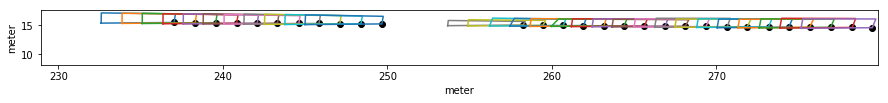

ID: 24261


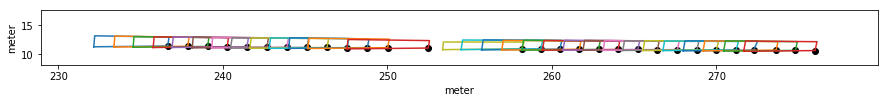

ID: 37261


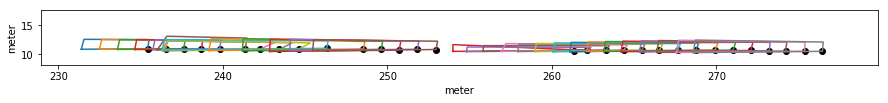

ID: 39261


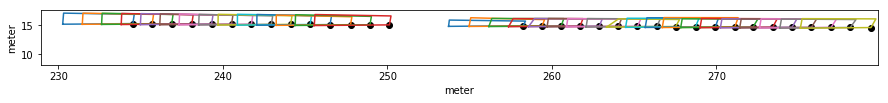

ID: 49261


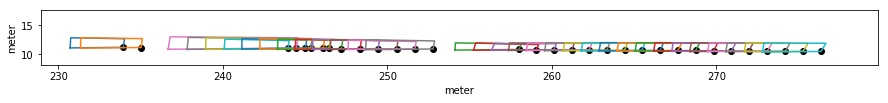

ID: 70261


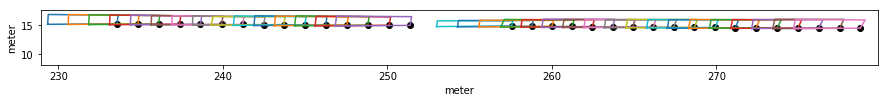

ID: 80261


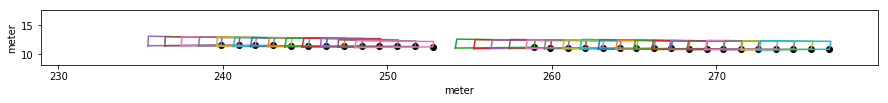

ID: 83261


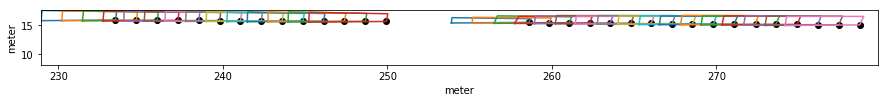

ID: 89261


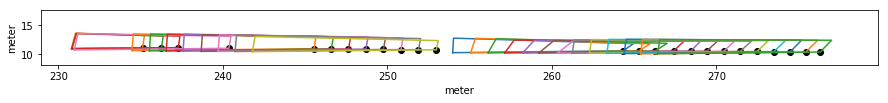

ID: 96261


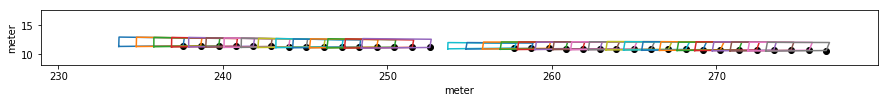

ID: 102261


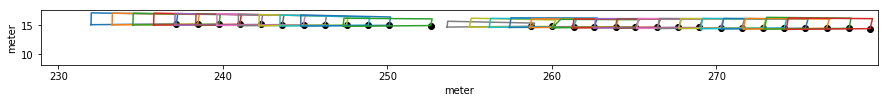

ID: 105261


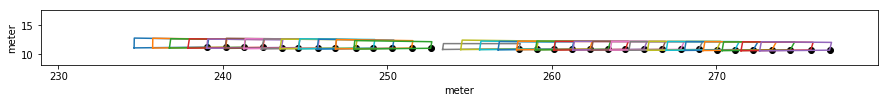

ID: 124261


KeyboardInterrupt: 

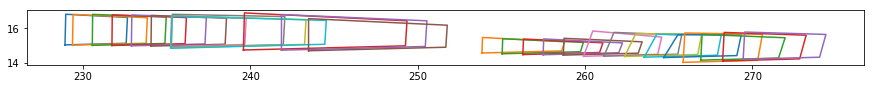

In [281]:
# plot original
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,' unique cars')

for i in range(nO):
    ID = groupList[i]
#     ID = 100261
    Y1 = groups.get_group(ID)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

    # plot 
    print('ID:',ID)
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black') # fbr
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 


35 unique cars
22261 58


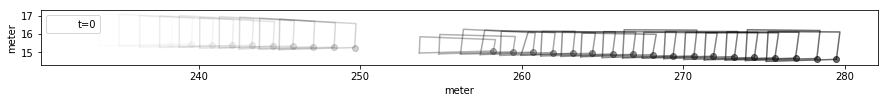

theta0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
positive x direction
1.4196364592371709 4.508598387263328


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


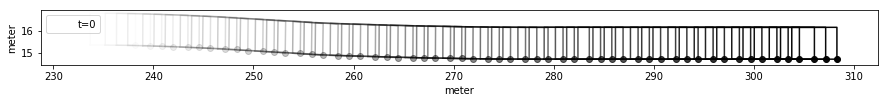

In [283]:
# correct only positive x direction
import utils
importlib.reload(utils)
import utils_optimization as opt
importlib.reload(opt)
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,'unique cars')

# for i in range(nO):
ID = groupList[0]
Y1 = groups.get_group(ID)
print(ID, len(Y1))

# plot 
D = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D)

Y1 = opt.rectify_single_camera(Y1)
# df = df[df['direction']>0]
# df = opt.rectify(df)  

# plot 
D = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D)

In [267]:
# debug direction -1
# unpack variables
timestamps = Y1['Timestamp'].values
timestamps= utils.nan_helper(timestamps)
dt = np.diff(timestamps)

# get bottom 4 points coordinates
pts = ['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']
pts_gps = ['bbrlat','bbrlon', 'fbrlat','fbrlon','fbllat','fbllon','bbllat', 'bbllon']
Y1 = np.array(Y1[pts])

# Euler forward dynamics
N = len(Y1) 
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = Y1[notNan,:]
a0 = np.zeros((N))
v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])

sign = np.sign(v0)
v0 = np.abs(v0)
x0 = (Y1[0,0]+Y1[0,6])/2
y0 = (Y1[0,1]+Y1[0,7])/2
theta = np.ones((N))*np.arccos(sign)
w = np.nanmean(np.abs(Y1[:,1]-Y1[:,7]))
l = np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))
v = np.zeros(N)
v[0] = v0
for k in range(0,N-2):
    v[k+1] = v[k] + a[k]*dt[k]
v[-1]=v[-2]

vx = v*cos(theta)
vy = v*sin(theta)

x = np.zeros(N)
y = np.zeros(N)
x[0] = x0
y[0] = y0

for k in range(0,N-1):
    x[k+1] = x[k] + vx[k]*dt[k]
    y[k+1] = y[k] + vy[k]*dt[k]

# compute positions
xa = x + w/2*sin(theta)
ya = y - w/2*cos(theta)
xb = xa + l*cos(theta)
yb = ya + l*sin(theta)
xc = xb - w*sin(theta)
yc = yb + w*cos(theta)
xd = xa - w*sin(theta)
yd = ya + w*cos(theta)
Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1)


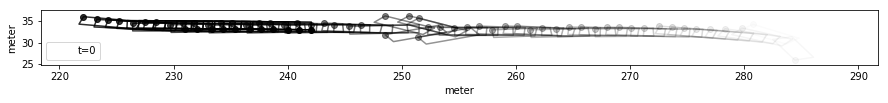

In [273]:
# plot 
D = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D)

In [4]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)

data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
output_path = data_path.joinpath('rectified')
path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')

A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002114, -86.607129]

for root,dirs,files in os.walk(str(data_path)):
    for file in files:
        if file.endswith(".csv") and file.startswith("record"):
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('reading ',camera_id,'...')
            df = utils.read_data(file_name,0,0)
            df = utils.img_to_gps(df, camera_id, path_vpts)
            df = utils.gps_to_road_df(df,A,B)
            df = utils.get_x_direction(df)
            df = utils.naive_filter_3D(df)
#             df = df[df['direction']>0]
            print('rectify data...')
            df = opt.rectify(df) 
            df = utils.gps_to_img(df, camera_id, path_vpts)
            print('saving new file...')
            new_name = 'rectified_'+file
            new_path = output_path.joinpath(new_name)
            df.to_csv(new_path)

            
# df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)            


reading  p2c1 ...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:69: RuntimeWarning: invalid value encountered in cos
  dx = r*cos(theta)*(lon2-lon1)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:178: RuntimeWarning: invalid value encountered in greater
  outliers = np.logical_or(w1>5, w2>5)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:186: RuntimeWarning: invalid value encountered in greater
  outliers =	abs(l1 - m1) > 2 * s1
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:184: RuntimeWarning: Mean of empty slice
  m1 = np.nanmean(l1)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


rectify data...


KeyboardInterrupt: 

In [27]:
# recorder df based on frame and time before saving
import utils
importlib.reload(utils)

data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
output_path = data_path.joinpath('rectified')

for root,dirs,files in os.walk(str(output_path)):
    for file in files:
        if file.endswith(".csv") and file.startswith("rectified_record_p2c1"):
            file_name = output_path.joinpath(file)
#             camera_id = utils.find_camera_id(file)
            print(file_name)
#             print('reading ',camera_id,'...')
            df = utils.read_data(file_name,0)

#             df = utils.img_to_gps(df, camera_id, path_vpts)
#             df = utils.gps_to_road_df(df,A,B)
#             df = utils.get_x_direction(df)
#             df = utils.naive_filter_3D(df)
#             print('rectify data...')
#             df = opt.rectify(df) 
#             df = utils.gps_to_img(df, camera_id, path_vpts)
            df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True) 
#             print('saving new file...')
#             new_name = 're_'+file
#             new_path = output_path.joinpath(new_name)
#             df.to_csv(new_path,index=False)

C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\..\2D-3D May 2021\rectified\rectified_record_p2c1_00001_track_outputs_corrected_3D.csv


In [24]:
import utils
importlib.reload(utils)

data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
output_path = data_path.joinpath('rectified')
video = str(data_path.joinpath('record_p2c1_00001_track_outputs_corrected_3D.csv_3D.mp4'))
label_file = str(output_path.joinpath('rectified_record_p2c1_00001_track_outputs_corrected_3D.csv'))

utils.plot_3D_csv(video,label_file,framerate = 30)

Finished writing C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\..\2D-3D May 2021\rectified\rectified_record_p2c1_00001_track_outputs_corrected_3D.csv_3D.mp4


73 unique cars
ID: 22261 Valid/total timestamps: 119 / 51 score: 1.573373030345485 runtime: 1.7426481246948242 
 width: 1.855302305157626 length: 4.2582315606482695


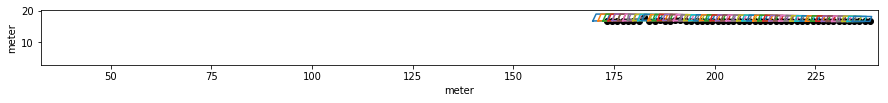

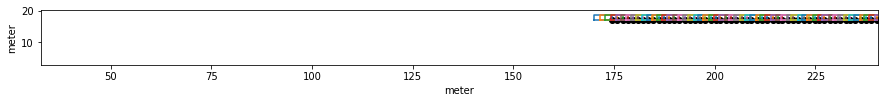

ID: 24261 Valid/total timestamps: 142 / 52 score: 0.10516391790702534 runtime: 5.111729621887207 
 width: 1.9961090841814693 length: 4.1362502652682345


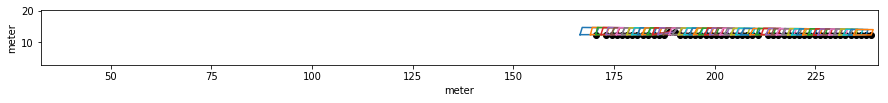

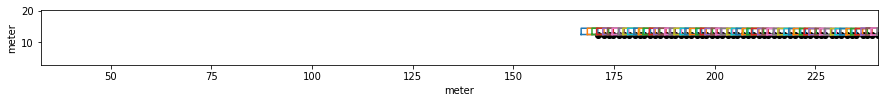

ID: 30261 Valid/total timestamps: 66 / 66 score: 0.17994508036569914 runtime: 0.6319575309753418 
 width: 2.170985862081438 length: 2.923257857475836


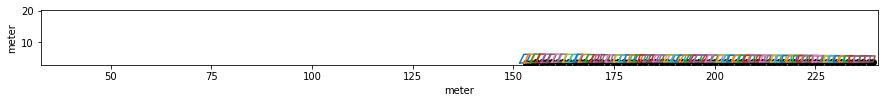

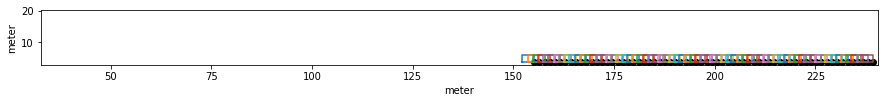

ID: 37261 Valid/total timestamps: 116 / 91 score: 0.1070224277359261 runtime: 4.941472053527832 
 width: 2.076333043572169 length: 3.81738921446181


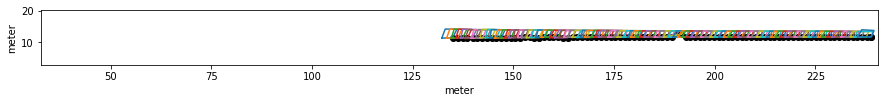

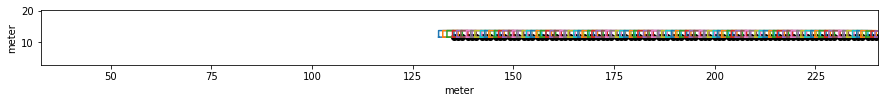

ID: 39261 Valid/total timestamps: 113 / 70 score: 2.182531821269367 runtime: 1.748654842376709 
 width: 2.0795028780831037 length: 4.19010920357351


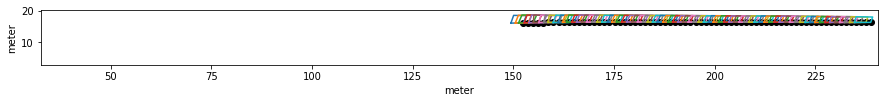

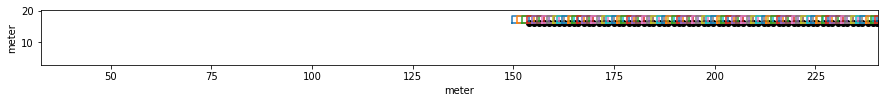

ID: 49261 Valid/total timestamps: 143 / 81 score: 0.11409576917341763 runtime: 5.459257125854492 
 width: 2.050778553484032 length: 3.208657733455257


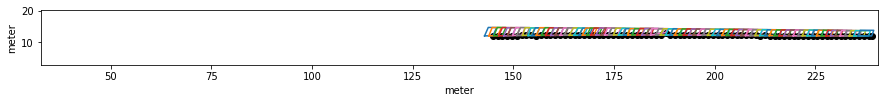

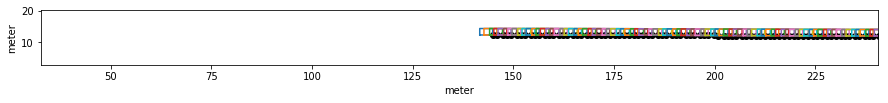

ID: 56261 Valid/total timestamps: 100 / 71 score: 0.2586114265771127 runtime: 1.6024374961853027 
 width: 2.0738968257507016 length: 3.986000254161072


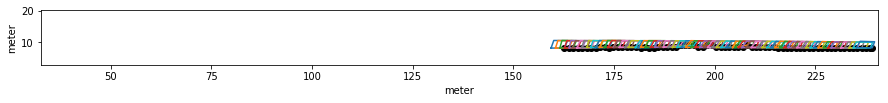

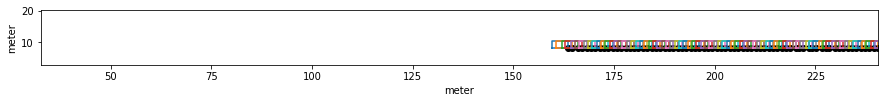

ID: 63261 Valid/total timestamps: 142 / 91 score: 0.1261641206480271 runtime: 5.54638409614563 
 width: 2.198544676359657 length: 3.2123961202136724


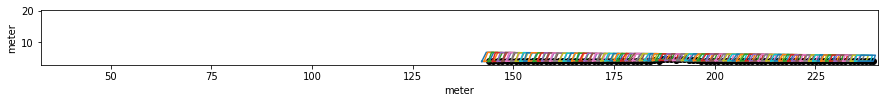

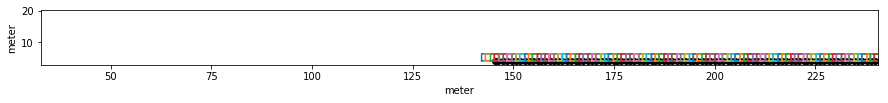

ID: 69261 Valid/total timestamps: 130 / 81 score: 0.12018602387004032 runtime: 5.045642375946045 
 width: 2.203242461770691 length: 4.427675733314485


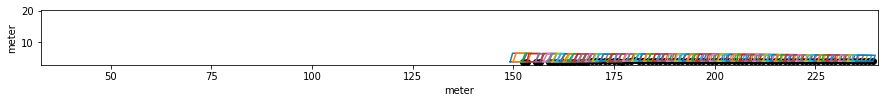

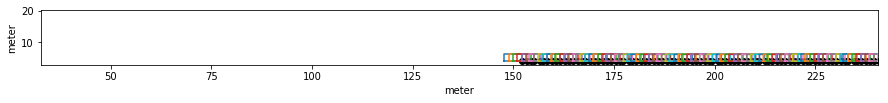

ID: 70261 Valid/total timestamps: 135 / 77 score: 0.11788622868398482 runtime: 6.1853532791137695 
 width: 1.9892482900674988 length: 3.631004750457374


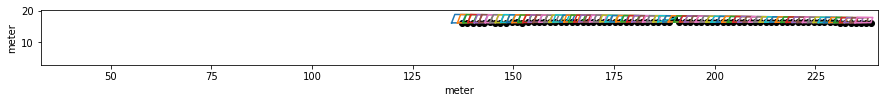

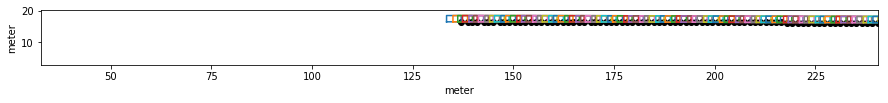

ID: 73261 Valid/total timestamps: 153 / 82 score: 0.09889421027223612 runtime: 5.758707523345947 
 width: 2.2450563140857493 length: 4.483754925139864


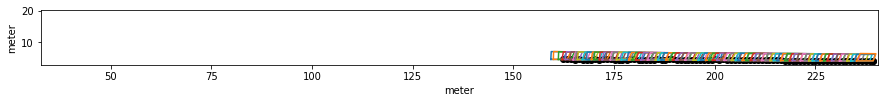

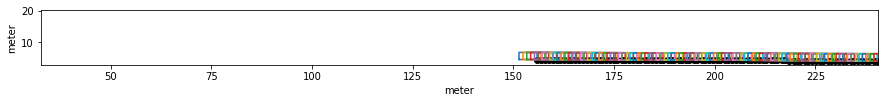

ID: 76261 Valid/total timestamps: 170 / 149 score: 0.35213937555334535 runtime: 6.204376459121704 
 width: 3.1323105433684906 length: 18.263262677734634


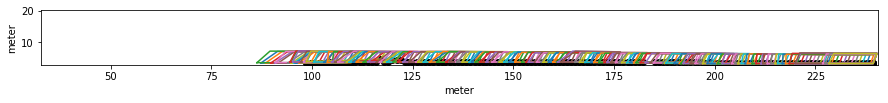

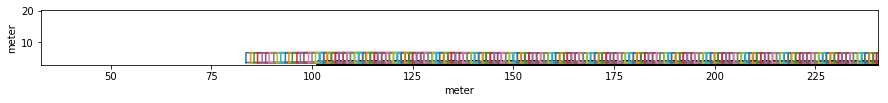

ID: 78261 Valid/total timestamps: 157 / 96 score: 0.13689552791208964 runtime: 2.2754435539245605 
 width: 2.2070957374952322 length: 3.443623628076701


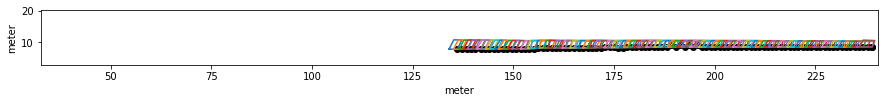

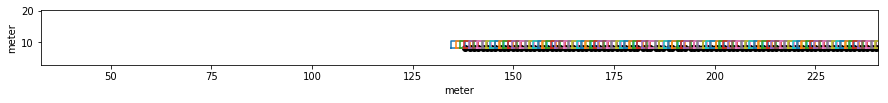

ID: 80261 Valid/total timestamps: 148 / 81 score: 0.2602962409212504 runtime: 2.1422393321990967 
 width: 1.9912269001086116 length: 3.1635404177958675


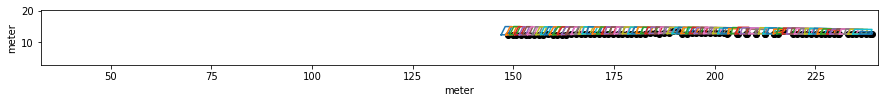

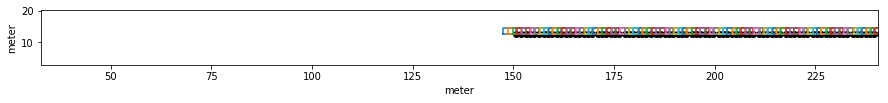

ID: 83261 Valid/total timestamps: 84 / 81 score: 0.23735781281007884 runtime: 1.2178401947021484 
 width: 2.096293352869825 length: 3.6969680258853526


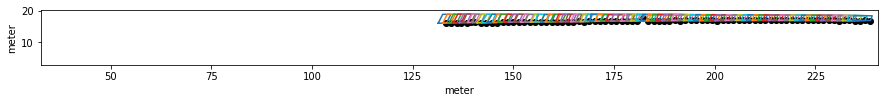

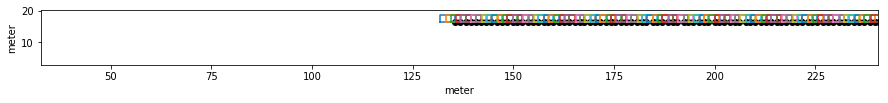

ID: 86261 Valid/total timestamps: 192 / 171 score: 0.3929515978450557 runtime: 3.9219443798065186 
 width: 3.991303595881424 length: 20.61431840212134


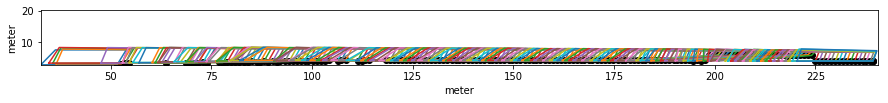

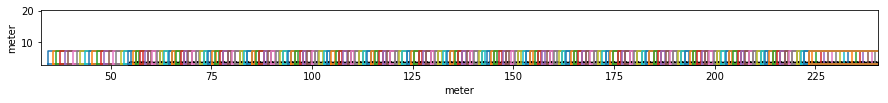

ID: 87261 Valid/total timestamps: 86 / 17 score: 36.37321147492437 runtime: 1.1747772693634033 
 width: 1.9968313387945429 length: 4.288621177346551


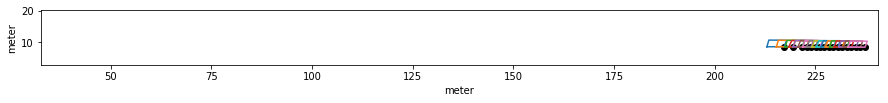

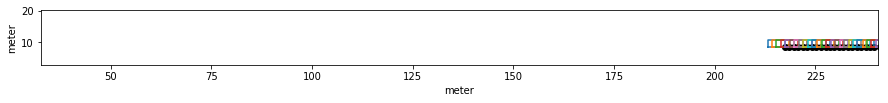

ID: 89261 Valid/total timestamps: 160 / 157 score: 0.26626971586938075 runtime: 2.9654862880706787 
 width: 3.132780704055305 length: 11.98044112185437


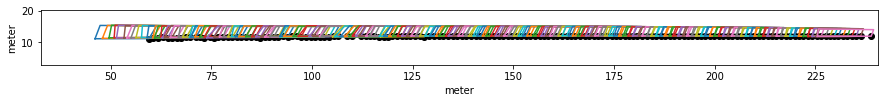

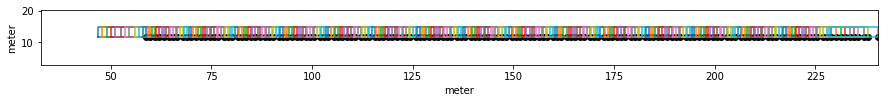

ID: 93261 Valid/total timestamps: 162 / 93 score: 0.2407953294692899 runtime: 3.1557741165161133 
 width: 2.4802788690549256 length: 4.727625231981044


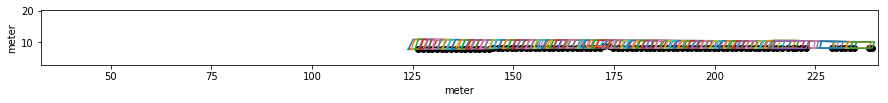

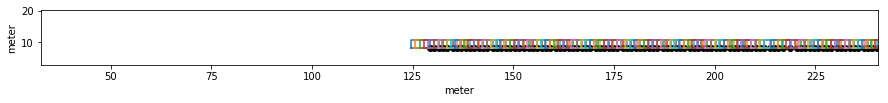

ID: 96261 Valid/total timestamps: 72 / 66 score: 0.3489442844666292 runtime: 0.625960111618042 
 width: 2.3349739153307603 length: 2.197409082506905


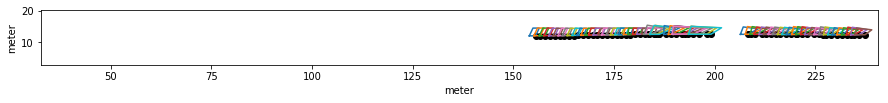

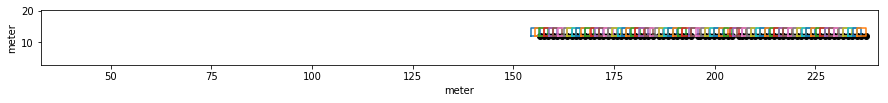

ID: 98261 Valid/total timestamps: 127 / 70 score: 0.24678313415856365 runtime: 2.0490970611572266 
 width: 2.1604870726754526 length: 3.9337101290351093


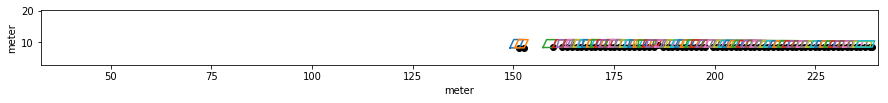

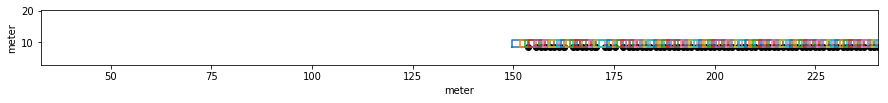

ID: 100261 Valid/total timestamps: 79 / 66 score: 0.23889357265160993 runtime: 4.1482720375061035 
 width: 2.277629734780369 length: 4.166031991158735


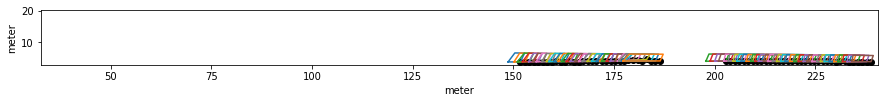

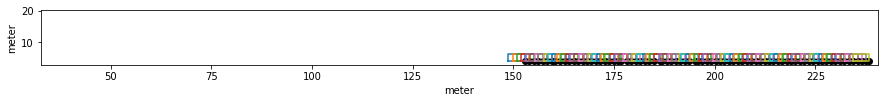

ID: 102261 Valid/total timestamps: 138 / 62 score: 1.4030620944659464 runtime: 2.1262168884277344 
 width: 2.1128417301687543 length: 4.946830348775129


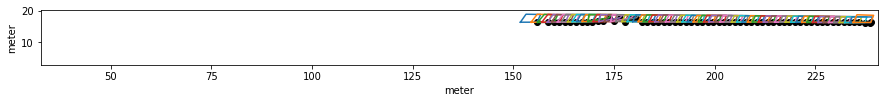

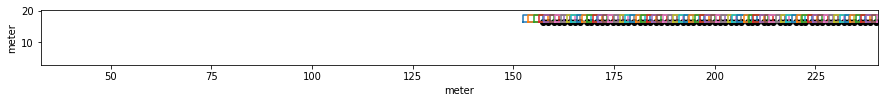

ID: 105261 Valid/total timestamps: 119 / 70 score: 0.5235064144255347 runtime: 2.0273191928863525 
 width: 2.002537333707382 length: 3.9369625598444924


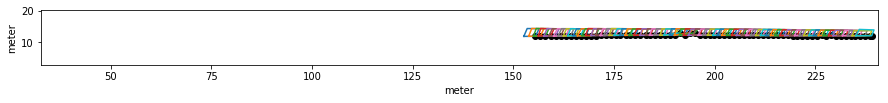

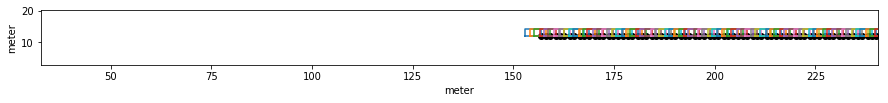

ID: 109261 Valid/total timestamps: 134 / 91 score: 0.20245222896796417 runtime: 6.041149377822876 
 width: 2.282773029126575 length: 3.3337779801299403


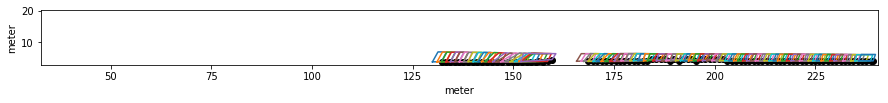

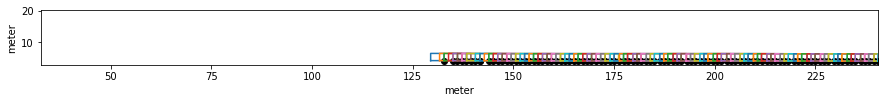

KeyboardInterrupt: 

In [28]:
import utils_optimization as opt
importlib.reload(opt)
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,'unique cars')
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega

score = np.zeros(nO) # record correction score

for i in range(nO):
    ID = groupList[i]
    Y1 = groups.get_group(ID)
    
    # impute missing timestamps
    timestamps = Y1['Timestamp'].values
    timestamps= utils.nan_helper(timestamps)
    dt = np.diff(timestamps)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    
    if len(Y1)<2:
        continue
        
    # Euler forward dynamics
    start = time.time()
    N = len(Y1) 
    notNan = ~np.isnan(np.sum(Y1,axis=-1))
    Y1 = Y1[notNan,:]
    a0 = np.zeros((N))
    theta0 = np.zeros((N))
    v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
    x0 = (Y1[0,0]+Y1[0,6])/2
    y0 = (Y1[0,1]+Y1[0,7])/2
    X0 = np.concatenate((a0.T, theta0.T, \
                         [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                          np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
    bnds = [(-5,5) for i in range(0,N)]+\
        [(-np.pi/8,np.pi/8) for i in range(N)]+\
        [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

    # Constraints definition (only for COBYLA, SLSQP and trust-constr)
    res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                    bounds=bnds, options={'disp': False,'maxiter':100000})#
    end = time.time()
    # extract results
    Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
    score[i] = LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('ID:',ID, 'Valid/total timestamps:',N, '/',np.count_nonzero(notNan),'score:',score[i],\
          'runtime:',end - start,'\n width:',w,'length:',l) 
    # plot 
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

    D = Yre
    fig, ax = plt.subplots(figsize=(15,1))
    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

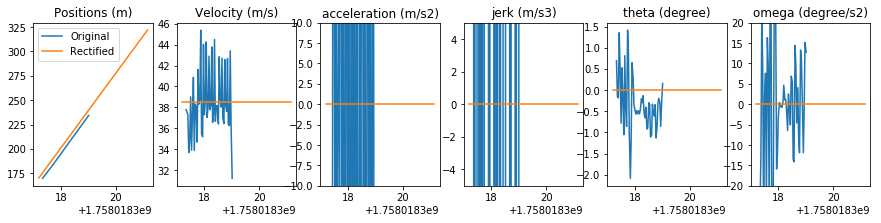

In [59]:
import utils
importlib.reload(utils)
# cx = (Y1[:,0]+Y1[:,6])/2
# cy = (Y1[:,1]+Y1[:,7])/2

fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(15,3))

ax1.plot(timestamps[notNan], Y1[:,0], label='Original')
ax1.plot(timestamps, Yre[:,0] , label='Rectified')
ax1.legend()
ax1.set_title('Positions (m)')
    
_,_,v1 = utils.calc_vel(Y1, timestamps[notNan])
# _,_,vre = utils.calc_vel(Yre,timestamps)
# v1 = np.diff(Y1[:,0], append=Y1[-1,0])
# vre = np.diff(Yre[:,0], append=Yre[-1,0])
ax2.plot(timestamps[notNan], v1, label='Original velocity')
ax2.plot(timestamps, v , label='Rectified velocity')
ax2.set_title('Velocity (m/s)')

a1 = utils.calc_accel(Y1[:,0], timestamps[notNan])
# are = utils.calc_accel(Yre[:,0],timestamps)
# a1 = np.diff(v1, append=v1[-1])
# are = np.diff(vre, append=vre[-1])
ax3.plot(timestamps[notNan], a1, label='Original accel')
ax3.plot(timestamps, a , label='Rectified accel')
ax3.set_title('acceleration (m/s2)')
ax3.set_ylim([-10,10])

# j1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
j1 = np.gradient(a1,timestamps[notNan])
jre = np.gradient(a, timestamps)
ax4.plot(timestamps[notNan], j1)
ax4.plot(timestamps, jre)
ax4.set_title('jerk (m/s3)')
ax4.set_ylim([-5,5])

theta1 = utils.calc_theta(Y1, timestamps[notNan])
# thetare = utils.calc_theta(Yre,timestamps)
ax5.plot(timestamps[notNan], np.degrees(theta1))
ax5.plot(timestamps, np.degrees(theta))
ax5.set_title('theta (degree)')

thetaddot1 = np.gradient(theta1,timestamps[notNan])
# thetaddotre = np.gradient(np.gradient(thetare)/dt)/dt
# theta1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
ax6.plot(timestamps[notNan], np.degrees(thetaddot1))
ax6.plot(timestamps, np.degrees(omega))
ax6.set_title('omega (degree/s2)')
ax6.set_ylim([-20,20])
plt.show()

In [60]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega
ID = 22261 
Y1 = groups.get_group(ID)
print(len(Y1))
print(Y1['bbr_x'])
timestamps = Y1['Timestamp'].values
# nans, x= utils.nan_helper_orig(timestamps)
# timestamps[nans]= np.interp(x(nans), x(~nans), timestamps[~nans])
timestamps= utils.nan_helper(timestamps)
dt = np.diff(timestamps)
print(dt)
# get bottom 4 points coordinates
Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

# Euler forward dynamics
start = time.time()
N = len(Y1) 
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = Y1[notNan,:]
a0 = np.zeros((N))
theta0 = np.zeros((N))
v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
x0 = (Y1[0,0]+Y1[0,6])/2
y0 = (Y1[0,1]+Y1[0,7])/2
X0 = np.concatenate((a0.T, theta0.T, \
                     [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                      np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
bnds = [(-5,5) for i in range(0,N)]+\
    [(-np.pi/8,np.pi/8) for i in range(N)]+\
    [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
end = time.time()
# extract results
Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
print('ID:',ID, 'N:',N, 'runtime:',end - start,'\n width:',w,'length:',l)


119
7             NaN
15            NaN
23            NaN
31            NaN
38     169.719018
          ...    
926           NaN
936           NaN
946           NaN
956           NaN
966           NaN
Name: bbr_x, Length: 119, dtype: float64
[0.03700733 0.03336787 0.03336787 0.03336787 0.03336787 0.03336811
 0.03336787 0.03278518 0.03395057 0.03336787 0.03336787 0.03336787
 0.03336787 0.03336787 0.03336787 0.03584218 0.0308938  0.02910614
 0.03999996 0.02999997 0.03000021 0.03999996 0.02999997 0.02999997
 0.03999996 0.02999997 0.02999997 0.0400002  0.02999997 0.02999997
 0.03999996 0.02999997 0.02999997 0.03999996 0.02999997 0.03000021
 0.03999996 0.02999997 0.03999996 0.02999997 0.02999997 0.03999996
 0.03000021 0.02999997 0.03999996 0.02999997 0.02999997 0.03999996
 0.02999997 0.02999997 0.0400002  0.02999997 0.02999997 0.03999996
 0.02999997 0.02999997 0.03999996 0.03000021 0.02999997 0.03999996
 0.02999997 0.02999997 0.03999996 0.02999997 0.02999997 0.0400002
 0.02999997 0.0299999

In [7]:
# least squares formulation just about the same run time and results
# try calculating the gradient of objective function
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
# try having simplified decision variables and no constraints


start = time.time()


p_dim = 2  # lp norm
p = 1

dt = np.gradient(timestamps)
lam1 = 1
lam2 = 0 # regularize acceleration 100
lam3 = 10 # regularize jerk
lam4 = 100 # regularize on thetaddot
lam5 = 100
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function
        X = [cx, cy, theta, w, l]^T
    """    
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]
    w = X[3*N]
    l = X[3*N+1]
    
    # compute positions
    xa = cx + w/2*sin(theta)
    ya = cy - w/2*cos(theta)
    xb = xa + l*cos(theta)
    yb = ya + l*sin(theta)
    xc = xb - w*sin(theta)
    yc = yb + w*cos(theta)
    xd = xa - w*sin(theta)
    yd = ya + w*cos(theta)
    Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1) 
    
    # min perturbation
    c1 = lam1*np.sum((Y1-Yre)**2)
    
#     # jerk regularization
#     v = np.gradient(cx,timestamps)/cos(theta)
#     a = np.gradient(v,timestamps)
#     j = np.gradient(a,timestamps)
#     c3 = lam3 * np.sum(j**2)

#     # theta ddot regularization
#     thetaddot = np.gradient(np.gradient(theta)/dt)/dt
#     c4 = lam4 * np.sum(thetaddot**2)
# #     print(c1,c3,c4)

#     # pfaffian constraint
#     vx = np.gradient(cx)/dt
#     vy = np.gradient(cy)/dt
#     c5 = lam5*np.sum((-vx*sin(theta)+vy*cos(theta))**2)
#     print(c1,c3,c4,c5)
    return c1 

def const5(X):
    # Pfaffian constraint
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]

    vx = np.gradient(cx)/dt
    vy = np.gradient(cy)/dt
    return -vx*sin(theta)+vy*cos(theta)
    
#     return np.sum(c5**2)
nlc = ({"type": "eq", "fun": const5})
# initial values
cx0 = (Y1[:,0]+Y1[:,6])/2
cy0 = (Y1[:,1]+Y1[:,7])/2
w0 = 1
l0 = 4
theta0 = np.zeros((N))
X0 = np.concatenate((cx0.T, cy0.T, theta0, [w0,l0]), axis=0)
bnds = [(0,np.inf) for i in range(0,2*N)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]+[(1,4),(2,50)]
list1, list2 = zip(*bnds)
bnd_list = (list(list1),list(list2))

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(obj, X0, method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
# BFGS: fast,ok
# L-BFGS-B: really fast, ok results
# CG: slow, ok
# COBLYA: fast but results no good
# SLSQP and fmin_slsqp: inequality cosntraints incompatible
# res = fmin_slsqp(obj, X0, # inequality constraint not compatible
#                 bounds=bnds, disp= True, iter=1000)
# res = least_squares(obj, X0, # super slow
#                 bounds=bnd_list, verbose = 2)
# res = shgo(obj,bounds=bnds)
end = time.time()
print(end - start)
# extract results
cx = res.x[:N]
cy = res.x[N:2*N]
theta = res.x[2*N:3*N]
w = res.x[3*N]
l = res.x[3*N+1]

Yre = utils.calc_positions(cx,cy,theta,w,l)
print(w,l)

0.3485264778137207
1.3014620637148426 4.276270081179986


In [76]:
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
import time
start = time.time()
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1
lam1 = 1000
lam2 = 100 # regularize acceleration
lam3 = 2 # regularize jerk
lam4 = 10 # regularize on thetaddot
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function"""    
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]

    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
    
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2
    
    # min perturbation
    c1 = lam1*LA.norm(Y1-Yre,2)
    
    # acceleration regularization
    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    v = np.sqrt(vx**2+vy**2)
    
    a = np.gradient(v)/dt
    c2 = lam2 * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam3 * LA.norm(j,2)

    # theta ddot regularization
    thetaddot = np.gradient(np.gradient(theta)/dt)/dt
    c4 = lam4 * LA.norm(thetaddot,2)
#     print(c1,c2,c3,c4)
    return c1 + c2 + c3 +c4

def const4(X):
    # rectangle shape constraint using theta
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    sos = np.sum((cx + w/2*sin(theta) - Yre[:,0])**2)\
        + np.sum((cy - w/2*cos(theta) - Yre[:,1])**2)\
        + np.sum((Yre[:,0]+l*cos(theta)-Yre[:,2])**2)\
        + np.sum((Yre[:,1]+l*sin(theta)-Yre[:,3])**2)\
        + np.sum((Yre[:,2]-w*sin(theta)-Yre[:,4])**2)\
        + np.sum((Yre[:,3]+w*cos(theta)-Yre[:,5])**2)\
        + np.sum((Yre[:,0]-w*sin(theta)-Yre[:,6])**2)\
        + np.sum((Yre[:,1]+w*cos(theta)-Yre[:,7])**2)
    return sos
#     return 0.0001-sos

def const5(X):
    # Pfaffian constraint
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    c5 = -vx*sin(theta)+vy*cos(theta)
    return np.sum(c5**2)
#     return 0.001-np.sum(c5**2)

nlc = ({"type": "eq", "fun": const4},
      {"type": "eq", "fun": const5})

Y1f = Y1.flatten('F')
theta0 = np.zeros((N))
X0 = np.concatenate((Y1f, [1.1, 3],theta0), axis=0)
bnds = [(0,np.inf) for i in range(0,8*N)]+[(1,4),(2,50)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]

res = minimize(obj, X0, method = 'SLSQP',
                constraints=nlc,
                bounds=bnds, options={'disp': True, 'maxiter':1000})

end = time.time()
print(end - start)

X_data = res.x[:8*N]
w = res.x[8*N]
l = res.x[8*N+1]
theta = res.x[8*N+2:]
#     theta = X[8*N+2:]
Yre = np.reshape(X_data,(-1,N)).T
# theta = utils.calc_theta(Yre, timestamps)
print(w,l)


TypeError: 'dict' object is not callable

In [84]:
# ver1: slow but accurate
# optimize on the road plane
# returns sigular matrix (constraints not continuous) if using equality constraints
import time

start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1


lam = 0.001 # regularize acceleration
lam2 = 0.0001 # regularize jerk
global lam, lam2, dt, Y1, timestamps

def obj(X):
    """The cost function"""   
#     global Yre, w, l
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
#     
    # min perturbation
    c1 = LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(Yre[:,0])
    v = dx/dt
    a = np.gradient(v)/dt
    c2 = lam * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam2 * LA.norm(j,2)
    return c1 + c2 + c3

def const1(X):
    # l, l, w, w, squared
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2)
#     return (Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2
          
def const2(X):
    # rectangle shape constraint
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]])**2)
#     return (Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]]).flatten('F')
                  
def const3(X):
    # follow straight lines movement and widthes are parallel to lanes
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.1 - np.std(Yre[:,3]) - np.std(Yre[:,1]) - np.std(Yre[:,5]) - np.std(Yre[:,7])
#     return np.std(Yre[:,3]) + np.std(Yre[:,1]) + np.std(Yre[:,5]) + np.std(Yre[:,7])


nlc = ({"type": "ineq", "fun": const1},
       {"type": "ineq", "fun": const2},
       {"type": "ineq", "fun": const3})
Y1f = Y1.flatten('F')
X0 = np.append(Y1f,[2.2, 4])
bnds = [(0,np.inf) for i in range(0,len(X0)-2)]+[(1,3),(2,np.inf)]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':1000})
end = time.time()
print(end - start)

X_data = res.x[:-2]
w = res.x[-2]
l = res.x[-1]
Yre = np.reshape(X_data,(-1,len(Y1))).T

print(w,l)


Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.814819920458618
            Iterations: 1001
            Function evaluations: 290232
            Gradient evaluations: 998
104.13162207603455
1.000000000000086 4.313711616444018


In [22]:
lat1, lon1 = A
lat2, lon2 = B
pt = 'bbl'
pt_lats = np.array(Y1[[pt+'lat']])
pt_lons = np.array(Y1[[pt+'lon']])
toA = utils.haversine_distance(lat1, lon1, pt_lats, pt_lons)
toAB = utils.pt_to_line_dist_gps(lat1, lon1, lat2, lon2, pt_lats, pt_lons)
x = np.sqrt(toA**2-toAB**2)

In [ ]:
# histogram of distance _y
n, bins, patches = plt.hist(x=Yre[:,2]-Yre[:,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# one-step ahead prediction from Y2 using vx and vy
def one_step_predict(Y, vx, vy, fps):
    Y2pred = Y.copy()
    Y2pred[:,[0,2,4,6]] = Y[:,[0,2,4,6]] + vx*1/fps
    Y2pred[:,[1,3,5,7]] = Y[:,[1,3,5,7]] + vy*1/fps
    return Y2pred

In [ ]:
# in lat/long per second
vx = (Y1.loc[Y1.index[-1]].bbrlat - Y1.loc[Y1.index[0]].bbrlat)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
vy = (Y1.loc[Y1.index[-1]].bbrlon - Y1.loc[Y1.index[0]].bbrlon)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
print(vx, vy)
Y3pred = one_step_predict(Y3, vx, vy, fps)

In [73]:
import utils
importlib.reload(utils)
AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
# print(utils.euclidean_distance(lats[0],lngs[0],lats[1],lngs[1]))
# print(utils.haversine_distance(lats[0],lngs[0],lats[1],lngs[1]))
utils.euclidean_distance(lats[0],lngs[0],Y1gps[:,0],Y1gps[:,1])

array([166.02834251, 167.21634731, 168.34819208, 169.6669836 ,
       170.77034016, 172.05936981, 173.27084343, 174.54504232,
       175.56284385, 176.88665959, 178.18531685, 179.32701601,
       180.6368458 , 181.84680672, 182.97507077, 184.37600768,
       185.49557427, 186.75461827, 192.83733281, 189.35870389,
       190.67234252, 192.04682815, 193.20266908, 194.50830515,
       195.83242475, 197.12840302, 198.51846321, 199.77310761,
       201.07637787, 202.40417507, 203.68813749, 205.0330999 ,
       206.33208362, 207.65670457, 208.88900684, 210.26975751,
       211.54065824, 212.8434962 , 214.2254466 , 215.50640658,
       216.76787543, 218.07329433, 219.46692237, 220.72960725,
       222.0342831 , 223.30060811, 224.57247823, 225.85950811,
       227.24299395, 228.47206544, 229.78535018, 231.00526153,
       232.3263121 , 233.62059252, 234.88210281,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

(51, 8)

In [85]:
Y1gps

(119, 8)